In [18]:
import numpy as np
import matplotlib.pyplot as plt
import nnmodel
import trainer

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import seaborn as sn

In [19]:
#Metode for å hente data frå mappe
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [20]:
#Hente data og sette til array
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [21]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [22]:
# Label array where BH is 0 and Sphalerons are 1
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [23]:
#Check if device is running on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [24]:
#Split data 75% into train and 25% into test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

Data augmentation process where we flip horizontally, vertically and rotate images by 180 degrees randomly thus increasing training set.

In [25]:
def crop_image(img, crop_width_percent=0.7):
    width = img.shape[2]
    new_width = int(width * crop_width_percent)
    left_margin = (width - new_width) // 2
    return img[:, :, left_margin:left_margin + new_width]

def pad_image(img, original_width):
    width = img.shape[2]
    padding_width = (original_width - width) // 2
    return np.pad(img, ((0, 0), (0, 0), (padding_width, padding_width)), mode='constant')

def augment_images(images):
    images = np.moveaxis(images, -1, 1)
    augmented_images = []
    for img in images:
        original_width = img.shape[2]
        img_cropped = crop_image(img)
        img_padded = pad_image(img_cropped, original_width)
        
        img_flipped_horizontal = np.flip(img_padded, axis=2)
        img_flipped_vertical = np.flip(img_padded, axis=1)
        img_rotated_180 = np.rot90(img_padded, 2, axes=(1, 2))

        augmented_images.extend(
            [img_padded, img_flipped_horizontal, img_flipped_vertical, img_rotated_180]
        )
    return np.array(augmented_images)

# Apply data augmentation only on the training set
augmented_trainData = augment_images(trainData)

# Repeat the labels for the training set to match the augmented dataset
trainLabels_repeated = np.repeat(trainLabels, 4)

# Convert the augmented training data and repeated labels to PyTorch tensors
augmented_trainData = torch.from_numpy(augmented_trainData)
trainLabels_repeated = torch.from_numpy(trainLabels_repeated)

# Create a TensorDataset from the augmented training data and repeated labels
train_augmented = torch.utils.data.TensorDataset(augmented_trainData, trainLabels_repeated)

# Create a DataLoader for the augmented training dataset with shuffle enabled and batch size of 50
trainLoader_augmented = DataLoader(train_augmented, shuffle=True, batch_size=50)

# Apply the same preprocessing step to the test set as the training set
testData_processed = np.moveaxis(testData, -1, 1)

# Create a TensorDataset for the test data
test = torch.utils.data.TensorDataset(torch.from_numpy(testData_processed), torch.from_numpy(testLabels))

# Create a DataLoader for the test data with shuffle and batch size
testLoader = DataLoader(test, shuffle=True, batch_size=50)

In [27]:
from torchsummary import summary

model = nnmodel.SymmetricNet(0.5).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           3,584
       BatchNorm2d-2          [-1, 128, 48, 48]             256
            Conv2d-3          [-1, 128, 48, 48]           3,584
       BatchNorm2d-4          [-1, 128, 48, 48]             256
            Conv2d-5          [-1, 128, 48, 48]           3,584
       BatchNorm2d-6          [-1, 128, 48, 48]             256
            Conv2d-7          [-1, 128, 48, 48]           3,584
       BatchNorm2d-8          [-1, 128, 48, 48]             256
         AvgPool2d-9          [-1, 128, 24, 24]               0
        AvgPool2d-10          [-1, 128, 24, 24]               0
        AvgPool2d-11          [-1, 128, 24, 24]               0
        AvgPool2d-12          [-1, 128, 24, 24]               0
          Dropout-13          [-1, 128, 24, 24]               0
           Conv2d-14          [-1, 256,

This is the code for training a neural network using PyTorch. Let me explain what happens at each step:

1. First, the function train takes in several arguments: the neural network model, train and test data loaders, the optimizer, the loss criterion, and the number of training epochs.

2. Initialize lists to store the training and testing loss, accuracy, and accuracy for each class.

3. Start the training loop for the specified number of epochs.

4. In each epoch, set the model to training mode. Then, for each batch of inputs and labels in the training data loader:
a. Move the inputs and labels to the device (GPU or CPU).
b. Zero out the gradients stored in the optimizer.
c. Pass the inputs through the model to get the outputs.
d. Compute the loss between the outputs and the labels.
e. Compute the gradients of the loss with respect to the model's parameters.
f. Update the model's parameters using the optimizer.
g. Accumulate the total loss and number of correct predictions for this epoch.

5. Calculate the average training loss and accuracy for this epoch.

6. Set the model to evaluation mode. Then, for each batch of inputs and labels in the testing data loader:
a. Move the inputs and labels to the device (GPU or CPU).
b. Pass the inputs through the model to get the outputs.
c. Compute the loss between the outputs and the labels.
d. Accumulate the total loss and number of correct predictions for this epoch.
e. Accumulate the total number of correct predictions for each class for this epoch.

7. Calculate the average testing loss and accuracy, and accuracy for each class for this epoch.

8. Print out the results for this epoch.

9. Append the metrics for this epoch to the lists.

10. Plot the training and testing loss and accuracy over all epochs, and the accuracy for each class over all epochs.

11. Plot the confusion matrix for the testing data using the predicted labels and true labels.

12. Repeat the process for each epoch until the specified number of epochs is reached.

In [13]:
def train(model, train_loader, test_loader, optimizer, criterion, n_epochs):
    
    # Initialize lists to store the metrics
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    black_holes_accs = []
    sphalerons_accs = []
    
    for epoch in range(n_epochs):
        # Train
        model.train() #set the model to train mode
        train_loss = 0
        correct = 0
        total = 0
    
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long() #Mode inputs and labels to the device
            optimizer.zero_grad() #Zero the gradients
            outputs = model(inputs).float() #Pass inputs to the model and get the outputs
            loss = criterion(outputs, labels) #calculate the loss
            loss.backward() #Backpropogate the loss
            optimizer.step() #Update the model parameters

            train_loss += loss.item() #Accumulate the trainings loss
            _, predicted = outputs.max(1) #Get the predictions
            total += labels.size(0) #Accumulate the number of examples
            correct += predicted.eq(labels).sum().item() #Accumulate the number of correct predictions
        
        train_acc = 100 * correct / total #Caulculate the training accuracy
        train_loss /= len(train_loader) #Average the training loss

        # Test
        model.eval() #Set the model to evaluation mode
        test_loss = 0
        correct = 0
        total = 0
        black_holes_correct = 0
        sphalerons_correct = 0
        black_holes_total = 0
        sphalerons_total = 0
        all_preds = []
        all_labels = []
        val_loss = 0

        with torch.no_grad(): #Disable gradient computation 
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device).float(), labels.to(device).long() #Move inputs and labels to device
                outputs = model(inputs).float() #Pass inputs to the model and get the outputs
                
                loss = criterion(outputs, labels) #Calculate the loss

                val_loss += loss.item()
                test_loss += loss.item()
                _, predicted = outputs.max(1) #Get the predictions
                total += labels.size(0) #Accumulate the number of examples
                correct += predicted.eq(labels).sum().item() #Accumulate the number of correct predictions

                # Separate accuracies for black holes and sphalerons
                black_holes_correct += (predicted * labels).sum().item()
                sphalerons_correct += ((1 - predicted) * (1 - labels)).sum().item()
                black_holes_total += labels.sum().item()
                sphalerons_total += (1 - labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())


        
        test_acc = 100 * correct / total
        black_holes_acc = 100 * black_holes_correct / black_holes_total
        sphalerons_acc = 100 * sphalerons_correct / sphalerons_total
        test_loss /= len(test_loader)
        # Calculate precision and recall
        precision, recall, _, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
        black_holes_precision, sphalerons_precision = precision
        black_holes_recall, sphalerons_recall = recall

        # Print results
        print(f"Epoch: {epoch+1}/{n_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

        # Append the metrics to the lists
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        black_holes_accs.append(black_holes_acc)
        sphalerons_accs.append(sphalerons_acc)
        black_holes_precisions.append(black_holes_precision)
        sphalerons_precisions.append(sphalerons_precision)
        black_holes_recalls.append(black_holes_recall)
        sphalerons_recalls.append(sphalerons_recall)

    # Plot the metrics
    plt.figure(figsize=(18, 9))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')

    plt.subplot(2, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(black_holes_accs, label='Black Holes Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Black Holes Accuracy')

    plt.subplot(2, 2, 4)
    plt.plot(sphalerons_accs, label='Sphalerons Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Sphalerons Accuracy')
    
    plt.subplot(2, 3, 5)
    plt.plot(black_holes_precisions, label='Black Holes Precision')
    plt.plot(sphalerons_precisions, label='Sphalerons Precision')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Black Holes and Sphalerons Precision')

    plt.subplot(2, 3, 6)
    plt.plot(black_holes_recalls, label='Black Holes Recall')
    plt.plot(sphalerons_recalls, label='Sphalerons Recall')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Black Holes and Sphalerons Recall')

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0, 1], ['Black Holes', 'Sphalerons'])
    plt.yticks([0, 1], ['Black Holes', 'Sphalerons'])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=16)

    plt.colorbar()
    plt.show()

Epoch: 1/15
Train Loss: 0.3142, Train Accuracy: 87.34%
Test Loss: 0.2403, Test Accuracy: 90.32%
Epoch: 2/15
Train Loss: 0.2511, Train Accuracy: 90.28%
Test Loss: 0.1995, Test Accuracy: 92.45%
Epoch: 3/15
Train Loss: 0.2301, Train Accuracy: 91.17%
Test Loss: 0.2452, Test Accuracy: 89.53%
Epoch: 4/15
Train Loss: 0.2183, Train Accuracy: 91.62%
Test Loss: 0.1984, Test Accuracy: 92.15%
Epoch: 5/15
Train Loss: 0.2097, Train Accuracy: 91.96%
Test Loss: 0.2460, Test Accuracy: 90.87%
Epoch: 6/15
Train Loss: 0.2050, Train Accuracy: 92.12%
Test Loss: 0.2162, Test Accuracy: 91.23%
Epoch: 7/15
Train Loss: 0.1991, Train Accuracy: 92.26%
Test Loss: 0.2470, Test Accuracy: 90.80%
Epoch: 8/15
Train Loss: 0.1970, Train Accuracy: 92.40%
Test Loss: 0.1904, Test Accuracy: 92.40%
Epoch: 9/15
Train Loss: 0.1913, Train Accuracy: 92.73%
Test Loss: 0.2075, Test Accuracy: 91.83%
Epoch: 10/15
Train Loss: 0.1870, Train Accuracy: 92.78%
Test Loss: 0.1784, Test Accuracy: 92.64%
Epoch: 11/15
Train Loss: 0.1845, Train 

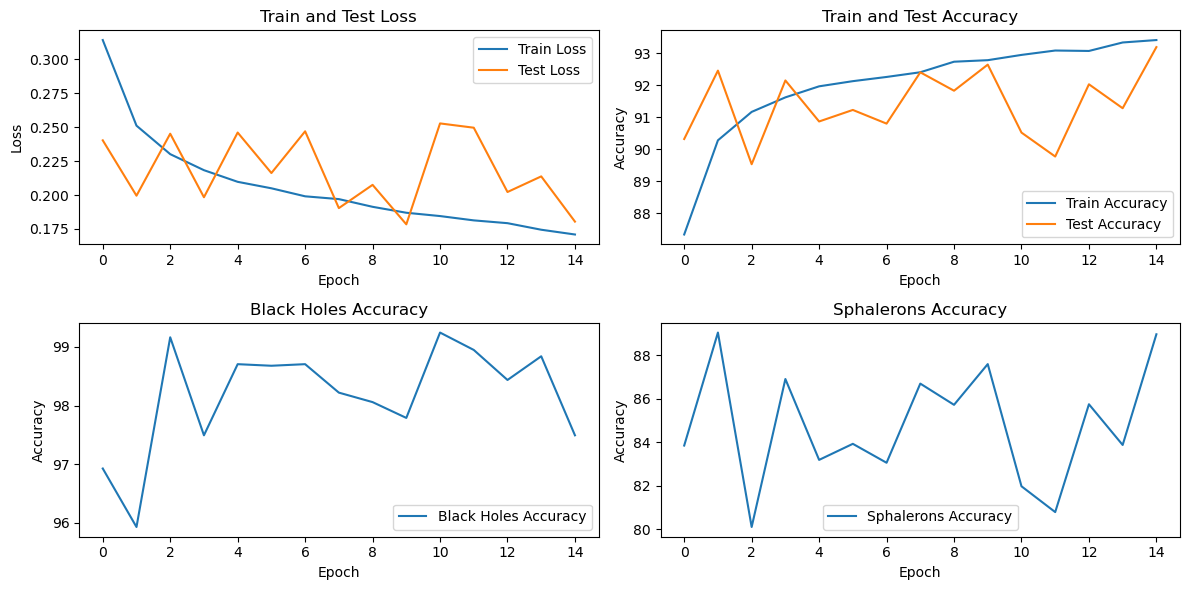

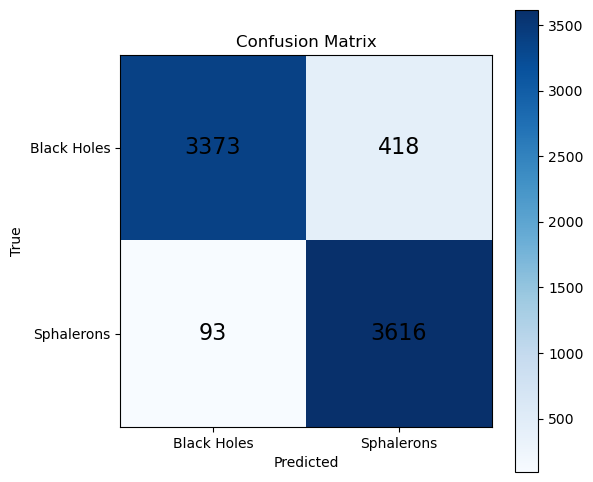

In [14]:
#Set the learning rate and number of epochs
n_epochs = 15

# Create the model
model = SymmetricNet(0.6).to(device)

# Set up the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

# Train the model
trainer.train(model, trainLoader_augmented, testLoader, optimizer, criterion, n_epochs)

Code below makes it possible to save model

In [15]:
# Define the file path to save the trained model
# model_path = 'model.pth'

# Train and save the model
# train(model, train_loader, test_loader, optimizer, criterion, n_epochs)
# torch.save(model.state_dict(), model_path)

In [16]:
# # Define the file path to load the saved model
# model_path = 'model.pth'

# # Create an instance of the model and load the saved state dictionary
# model = SymmetricNet(dropout=0.25)
# model.load_state_dict(torch.load(model_path))